In [1]:
import os
import time

import dill as pickle

import functools
import operator
from datetime import datetime, timedelta
from multiprocessing import Pool
import shutil

import numpy as np
import pandas as pd
pd.options.display.max_rows = 99
pd.options.display.max_columns = 99
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from covid_model_deaths.data import get_input_data, plot_crude_rates, DeathModelData
from covid_model_deaths.social_distancing_cov import SocialDistCov
from covid_model_deaths.drawer import Drawer
from covid_model_deaths.utilities import CompareModelDeaths, MOBILITY_SOURCES, KS, RATE_THRESHOLD, submit_curvefit, get_peak_date
from covid_model_deaths.impute_death_threshold import impute_death_threshold
from covid_model_deaths.moving_average import moving_average_predictions
from covid_model_deaths.compare_moving_average import CompareAveragingModelDeaths

from db_queries import get_location_metadata

import warnings
warnings.simplefilter('ignore')

## Set arguments and run settings ##
# Set some arguments and settings #
RUN_TYPE = 'dev'
DATESTAMP_LABEL = '2020_04_22_Counties'
DATA_VERSION = 'hospitals-and-counties/best' #'best'
PEAK_FILE = '/ihme/covid-19/deaths/mobility_inputs/2020_04_14/final_peak_locs_04_14.csv'
CASES_DEATHS_FILE = '/ihme/covid-19/deaths/mobility_inputs/2020_04_20/deaths_from_cases.csv'
lsvid = 641

CODE_DIR = os.path.abspath('../src/covid_model_deaths')
OUTPUT_DIR = f'/ihme/covid-19/deaths/{RUN_TYPE}/{DATESTAMP_LABEL}'

# Are we combining with previous predictions?
combine_predictions = True
raw_draw_path = f'{OUTPUT_DIR}/euro_data.csv'
average_draw_path = f'{OUTPUT_DIR}/past_avg_euro_data.csv'
yesterday_draw_path = '/ihme/covid-19/deaths/prod/2020_04_19_Europe/euro_data.csv'
before_yesterday_draw_path = '/ihme/covid-19/deaths/prod/2020_04_17_Europe/euro_data.csv'

# ensemble plot settings
COLOR_DICT = {
    'safegraph':'dodgerblue',
    'google':'forestgreen',
    'descartes':'firebrick'
    #'equal':'gold',
    #'ascmid':'firebrick',
    #'ascmax':'darkviolet'
}
LINE_DICT = {
    #'14':'-',
    '21':'--'
}


In [2]:
# CODE_DIR = os.path.abspath('../src/covid_model_deaths')
# OUTPUT_DIR = f'/ihme/covid-19/deaths/{RUN_TYPE}/{DATESTAMP_LABEL}'

if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)
print(f'Writing to {OUTPUT_DIR}')


Writing to /ihme/covid-19/deaths/dev/2020_04_22_Counties


In [3]:
# come up with more informative names...
input_full_df = get_input_data('full_data', DATA_VERSION)
input_death_df = get_input_data('deaths', DATA_VERSION)
input_age_pop_df = get_input_data('age_pop', DATA_VERSION)
input_age_death_df = get_input_data('age_death', DATA_VERSION)

# manually adjust Iceland spike (0 deaths to 5 deaths to 0 deaths in March...)
input_full_df.loc[(input_full_df['Country/Region'] == 'Iceland') & (input_full_df['Date'] == pd.Timestamp('2020-03-15')), ['Deaths', 'Death rate']] = 0
input_death_df = input_death_df.loc[(input_death_df['Country/Region'] != 'Iceland') | (input_death_df['Date'] != pd.Timestamp('2020-03-15'))]
input_death_df.loc[input_death_df['Country/Region'] == 'Iceland', 'Days'] = input_death_df.loc[
    input_death_df['Country/Region'] == 'Iceland', 'Date'
].apply(lambda x: (x - input_death_df.loc[input_death_df['Country/Region'] == 'Iceland', 'Date'].min()).days)

# drop Georgia the country until we fix location_ids
input_full_df = input_full_df[input_full_df['Country/Region'] != 'Georgia'].reset_index(drop=True)
input_death_df = input_death_df[input_death_df['Country/Region'] != 'Georgia'].reset_index(drop=True)

# Change location_id for Miami
miami = input_full_df[input_full_df['location_id'] == 60408]
miami['location_id'] = 957
input_full_df = input_full_df.append(miami)
input_full_df = input_full_df[input_full_df['location_id'] != 60408]

# And in input_death_df
miami = input_death_df[input_death_df['location_id'] == 60408]
miami['location_id'] = 957
input_death_df = input_death_df.append(miami)
input_death_df = input_death_df[input_death_df['location_id'] != 60408]

# # make a picture
# plot_crude_rates(input_death_df)


## Fix closure sheet (is occurring in social_distancing_cov.py)
I feel like this should work but it doesn't. I believe this is because the values are converted to floats, which don't merge later. 
I am making the change directly in the closure_criteria_sheet.xlsx because I can't figure out how to fix it here.
I am assuming that the counties have the same closures as the state. 

In [4]:
#/ihme/covid-19/model-inputs/{data_version}/closure_criteria_sheet.xlsx
df = pd.read_excel(f'/ihme/covid-19/model-inputs/hospitals-and-counties/best/closure_criteria_sheet.xlsx')

ca_ids = [787,790,792,794,796,799,814]
ca_names = ['Marin County','Contra Costa County','San Francisco County','Alameda County','San Mateo County','Santa Clara County','Los Angeles County']
for location_id, location in zip(ca_ids, ca_names):
    nrep = df[df['location_id'] == 527]
    nrep['merge_name'] = location
    nrep['location_id'] = location_id
    df = df.append(nrep)
ny_ids = [60410, 60411]
ny_names = ['New York Metropolitan Area', 'Outside of New York City']
for location_id, location in zip(ny_ids, ny_names):
    nrep = df[df['location_id'] == 555]
    nrep['merge_name'] = location
    nrep['location_id'] = location_id
    df = df.append(nrep)
    
nrep = df[df['location_id'] == 558]
nrep['merge_name'] = 'UC Health'
nrep['location_id'] = int(60416)
df = df.append(nrep)    

nrep = df[df['location_id'] == 532]
nrep['merge_name'] = 'Miami'
nrep['location_id'] = 957
df = df.append(nrep)  

# df['location_id'] = df['location_id'].astype(int)
df.head(10)

,merge_name,country,admin1,specific_location,People instructed to stay at home,Educational facilities closed,"Non-essential services closed (i.e., bars/restaurants)",Rationing of supplies and requsitioning of facilities,Travel severely limited,Major reprioritisation of healthcare services,source [people instructed to stay at home],source [educational facilities closed],"source [non-essential services closed (i.e., bars/restaurants)]",source [rationing of supplies and requsitioning of facilities],source [travel severely limited],source [major reprioritisation of healthcare services],Any Gathering Restrictions,Any Business Closures,source [any gathering restrictions],source [any business closures],notes and additional information,date checked,Prior NE services closing date,Prior NE services closing links,location_id
0,NaN,NaN,NaN,NaN,"State-level decree for people to ""stay home"" o...",State-level closure of schools (public and/or ...,"State-level closure of non-essential services,...",?,checkpoints with guards [e.g. in Wuhan you had...,State-level reorganization of healthcare prior...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"Wuhan City, Hubei",China,Hubei,Wuhan,23.01.2020,23.01.2020,23.01.2020,23.01.2020,23.01.2020,23.01.2020,http://wjw.hubei.gov.cn/fbjd/dtyw/202001/t2020...,NaN,NaN,NaN,NaN,NaN,full implementation,full implementation,NaN,NaN,Assumed all criteria fulfilled on 23.01.2020 [...,2020-04-11 00:00:00,NaN,NaN,60412.0
2,Baden-Wurttemberg,Germany,Baden-Wurttemberg,NaN,21.03.2020,17.03.2020,21.03.2020,NaN,not implemented,NaN,https://stm.baden-wuerttemberg.de/fileadmin/re...,https://stm.baden-wuerttemberg.de/fileadmin/re...,https://stm.baden-wuerttemberg.de/fileadmin/re...,NaN,NaN,NaN,full implementation,full implementation,NaN,NaN,"Again, unclear if was updated on 23rd March, o...",2020-04-11 00:00:00,NaN,NaN,60377.0
3,Bavaria,Germany,Bavaria,NaN,21.03.2020,16.03.2020,21.03.2020,NaN,not implemented,NaN,https://www.stmgp.bayern.de/presse/ausgangsbes...,https://www.reuters.com/article/us-health-coro...,https://www.stmgp.bayern.de/presse/ausgangsbes...,NaN,NaN,NaN,full implementation,17.03.2020,NaN,NaN,NaN,2020-04-11 00:00:00,NaN,NaN,60378.0
4,Berlin,Germany,Berlin,NaN,23.03.2020,23.03.2020,23.03.2020,NaN,not implemented,NaN,https://www.berlin.de/corona/en/measures/,https://www.berlin.de/corona/massnahmen/verord...,https://www.berlin.de/corona/massnahmen/verord...,NaN,NaN,NaN,full implementation,14.03.2020,NaN,NaN,Unclear if is stay-at-home order,2020-04-11 00:00:00,NaN,NaN,60379.0
5,Brandenburg,Germany,Brandenburg,NaN,17.03.2020,18.03.2020,17.03.2020,NaN,not implemented,NaN,https://www.maerkisch-oderland.de/de/datei/anz...,https://www.maerkisch-oderland.de/de/datei/anz...,https://www.maerkisch-oderland.de/de/datei/anz...,NaN,NaN,NaN,full implementation,full implementation,NaN,NaN,NaN,2020-04-11 00:00:00,NaN,NaN,60380.0
6,Bremen,Germany,Bremen,NaN,22.03.2020,16.03.2020,20.03.2020,NaN,not implemented,NaN,https://www.bundesregierung.de/breg-de/themen/...,https://www.senatspressestelle.bremen.de/detai...,https://www.amtliche-bekanntmachungen.bremen.d...,NaN,NaN,NaN,full implementation,full implementation,NaN,NaN,NE: list of essential businesses derived from ...,2020-04-11 00:00:00,NaN,NaN,60381.0
7,Hamburg,Germany,Hamburg,NaN,22.03.2020,16.03.2020,not implemented,NaN,not implemented,NaN,https://www.hamburg.de/allgemeinverfuegungen/1...,https://www.hamburg.de/coronavirus/pressemeldu...,NaN,NaN,NaN,NaN,full implementation,15.03.2020,NaN,NaN,NaN,2020-04-11 00:00:00,NaN,NaN,60382.0
8,Hesse,Germany,Hesse,NaN,22.03.2020,16.03.2020,not implemented,NaN,not implemented,NaN,https://www.hessen.de/presse/pressemitteilung/...,https://www.hessen.de/presse/pressemitteilung/...,https://www.hessen.de/presse/pressemitteilung/...,NaN,NaN,NaN,full implementation,15.03.2020,NaN,NaN,Useful timeline - https://www.hessen.de/fuer-b...,2020-04-11 00:00:00,22.03.2020,NaN,60383.0
9,Mecklenburg-Western Pomerania,Germany,Mecklenburg-W

# Some counties and states are missing age curves

In [5]:
# A fatal error: Florida and New York have no age-curve populations!
# Also missing data for many new CA counties
# Not sure of an efficient way to do this but here we go
fill_pops = pd.read_csv('/ihme/covid-19/model-inputs/best/age_pop.csv')
fl_pops = fill_pops[fill_pops['location_id'] == 532]
ny_pops = fill_pops[fill_pops['location_id'] == 555]
ca_pops = fill_pops[fill_pops['location_id'] == 527]
st_pops = fill_pops[fill_pops['location_id'] == 558]
input_age_pop_df = input_age_pop_df.append(fl_pops)
input_age_pop_df = input_age_pop_df.append(ny_pops)
input_age_pop_df = input_age_pop_df.append(ca_pops)
input_age_pop_df = input_age_pop_df.append(st_pops)

# Remove empty rows for 

# Now add counties sequentially
county_ids = [787, 790, 792, 794, 796, 799]
input_age_pop_df = input_age_pop_df[input_age_pop_df['location_id'] != 787]
input_age_pop_df = input_age_pop_df[input_age_pop_df['location_id'] != 790]
input_age_pop_df = input_age_pop_df[input_age_pop_df['location_id'] != 792]
input_age_pop_df = input_age_pop_df[input_age_pop_df['location_id'] != 794]
input_age_pop_df = input_age_pop_df[input_age_pop_df['location_id'] != 796]
input_age_pop_df = input_age_pop_df[input_age_pop_df['location_id'] != 799]
for ids in county_ids:
    county_pops = ca_pops
    county_pops['location_id'] = ids
    input_age_pop_df = input_age_pop_df.append(county_pops)
    
# Change location_id for Miami
miami = input_age_pop_df[input_age_pop_df['location_id'] == 60408]
miami['location_id'] = 957
input_age_pop_df = input_age_pop_df.append(miami)
 
#input_age_pop_df.tail(75)

## identify locations we are running
#### location sets posted in slack channel

In [6]:
# get locaton_ids
# Changed this so we can set at the top
loc_df = get_location_metadata(location_set_id=112, location_set_version_id=lsvid)

# Drop any locations in the US and keep only most detailed for modeling
euro_df = loc_df.loc[
    (loc_df['most_detailed']==1) & ~loc_df['path_to_top_parent'].str.startswith('102,'),
    ['location_id', 'location_ascii_name', 'parent_id', 'level', 'most_detailed']
]

# format
euro_df = euro_df.rename(index=str, columns={'location_ascii_name':'Location'})
loc_df = loc_df[['location_id', 'location_ascii_name']]
loc_df = loc_df.rename(index=str, columns={'location_id':'parent_id',
                                           'location_ascii_name':'Country/Region'})
euro_df = euro_df.merge(loc_df)

# Dropping these locations due to an error in the hierarchy -- non-mutually exclusive (relevant for lsvid 637)
euro_df = euro_df.loc[(euro_df.most_detailed == 1) &
                      (~euro_df.location_id.isin([53451, 53452, 53474])),
                      ['location_id', 'Location', 'Country/Region', 'level']]
# Dropping counties without more than 1 day of data
euro_df = euro_df.loc[(~euro_df.location_id.isin([780, 781, 787, 789, 790, 792, 794, 796, 799, 60414])),
                      ['location_id', 'Location', 'Country/Region', 'level']]
euro_df

,location_id,Location,Country/Region,level
9,814,Los Angeles County,Los Angeles County,0
10,957,Miami-Dade County,Miami-Dade County,0
11,60410,New York Metropolitan Area,New York Metropolitan Area,0
13,60411,Outside of New York City,Outside of New York City,0
14,60416,UC Health,UC Health,0


## prepare data for case-to-death

In [18]:
%%capture

location_ids = sorted(input_full_df.loc[(np.log(input_full_df['Death rate']) > RATE_THRESHOLD),
                                  'location_id'].unique())

start_time = datetime.now()
def combine_cases_w_backcast_deaths(location_id, input_death_df, input_age_pop_df, input_age_death_df, rate_threshold):
    mod_df = DeathModelData(input_death_df, input_age_pop_df, input_age_death_df, location_id, 'threshold', rate_threshold=RATE_THRESHOLD).df
    mod_df = mod_df.loc[mod_df['location_id'] == location_id].reset_index(drop=True)
    if len(mod_df) > 0:
        date0 = mod_df['Date'].min()
        day0 = mod_df.loc[~mod_df['Date'].isnull(), 'Days'].min()
        mod_df.loc[mod_df['Days'] == 0, 'Date'] = date0 - timedelta(days=np.round(day0))
        mod_df = mod_df.loc[~((mod_df['Deaths'].isnull()) & (mod_df['Date'] == date0))]
        mod_df = mod_df.loc[~mod_df['Date'].isnull()]
        mod_df.loc[mod_df['Death rate'].isnull(), 'Death rate'] = np.exp(mod_df['ln(age-standardized death rate)'])
        mod_df.loc[mod_df['Deaths'].isnull(), 'Deaths'] = mod_df['Death rate'] * mod_df['population']
        mod_df = mod_df.rename(index=str, columns={'Location':'Province/State'})
    else:
        mod_df = pd.DataFrame(
            columns=['location_id', 'Province/State', 'Country/Region', 'Date', 'Deaths', 'Death rate', 'population']
        )

    return mod_df[['location_id', 'Province/State', 'Country/Region', 'Date', 'Deaths', 'Death rate', 'population']].reset_index(drop=True)

_combiner = functools.partial(combine_cases_w_backcast_deaths,
                              input_death_df=input_death_df,
                              input_age_pop_df=input_age_pop_df,
                              input_age_death_df=input_age_death_df,
                              rate_threshold=RATE_THRESHOLD)
pool = Pool(20)
loc_dfs = pool.map(_combiner, location_ids)
pool.close()
pool.join()
loc_df = pd.concat(loc_dfs)
loc_df = input_full_df[['location_id', 'Province/State', 'Country/Region', 'Date', 'Confirmed', 'Confirmed case rate']].merge(
    loc_df, how='outer'
).reset_index(drop=True)
loc_df.loc[loc_df['Province/State'].isnull(), 'Province/State'] = loc_df['Country/Region']
loc_df['location_id'] = loc_df['location_id'].astype(int)
loc_df.to_csv(f'{OUTPUT_DIR}/backcast_for_case_to_death.csv', index=False)


In [19]:
date_df = impute_death_threshold(loc_df,
                                 location_list=euro_df['location_id'].unique().tolist(),
                                 ln_death_rate_threshold=RATE_THRESHOLD)
id_map_df = input_full_df[['location_id', 'Province/State', 'Country/Region']].drop_duplicates()
id_map_df.loc[id_map_df['Province/State'].isnull(), 'Province/State'] = id_map_df['Country/Region']
del id_map_df['Country/Region']
id_map_df = id_map_df.rename(index=str, columns={'Province/State':'location'})
date_df = id_map_df[['location_id', 'location']].merge(date_df)
date_df.to_csv(f'{OUTPUT_DIR}/threshold_dates.csv', index=False)
del loc_df
del id_map_df
end_time = datetime.now()
print(end_time - start_time)


0:03:40.443067


## pops

In [9]:
# store pops for Bobby
pop_df = input_age_pop_df.merge(euro_df).reset_index(drop=True)
pop_df[['location_id', 'Location', 'age_group', 'population']].to_csv(f'{OUTPUT_DIR}/pops.csv', index=False)
print(f'{OUTPUT_DIR}/pops.csv')


/ihme/covid-19/deaths/dev/2020_04_22_Counties/pops.csv


## store model data and covariate data, submit models

In [10]:
# method for getting dates
def date_mean(dates):
    dt_min = dates.min()
    deltas = [x-dt_min for x in dates]

    return dt_min + functools.reduce(operator.add, deltas) / len(deltas)

# get mean data from dataset
date_draws = [i for i in date_df.columns if i.startswith('death_date_draw_')]
date_mean_df = date_df.copy()
date_mean_df['threshold_date'] = date_mean_df.apply(
    lambda x: datetime.strptime(date_mean(x[date_draws]).strftime('%Y-%m-%d'), '%Y-%m-%d'),
    axis=1
)
date_mean_df = date_mean_df.rename(index=str, columns={'location':'Location'})
country_label_df = input_full_df[['Province/State', 'Country/Region']].drop_duplicates().reset_index(drop=True)
country_label_df.loc[country_label_df['Province/State'].isnull(), 'Province/State'] = country_label_df['Country/Region']
country_label_df = country_label_df.rename(index=str, columns={'Province/State':'Location'})
date_mean_df = date_mean_df.merge(country_label_df, how='outer')
if date_mean_df['Country/Region'].isnull().any():
    raise ValueError('Trouble attaching country names,')
date_mean_df = date_mean_df[['location_id', 'Location', 'Country/Region', 'threshold_date']]

# set up ensemble
def get_out_dirs(model_labels):
    model_out_dirs = []
    for model_label in model_labels:
        for k in KS:
            # set up dirs
            model_out_dir = f'{OUTPUT_DIR}/model_data_{model_label}_{k}'
            if not os.path.exists(model_out_dir):
                os.mkdir(model_out_dir)
            model_out_dirs.append(model_out_dir)

    return model_out_dirs
def get_draw_list(n_scenarios):
    n_draws_list = [int(1000 / n_scenarios)] * n_scenarios
    n_draws_list[-1] = n_draws_list[-1] + 1000 - np.sum(n_draws_list)

    return n_draws_list

# prepare last day dataset
last_day_df = input_full_df.copy()
last_day_df['last_day'] = last_day_df.groupby('location_id', as_index=False)['Date'].transform(max)
last_day_df = last_day_df.loc[last_day_df['Date'] == last_day_df['last_day']].reset_index(drop=True)
last_day_df['location_id'] = last_day_df['location_id'].astype(int)
last_day_df.loc[last_day_df['Death rate'] == 0, 'Death rate'] = 0.1 / last_day_df['population']
last_day_df['ln(death rate)'] = np.log(last_day_df['Death rate'])
last_day_df = last_day_df[['location_id', 'ln(death rate)', 'Date']].merge(date_mean_df)
last_day_df['Days'] = (last_day_df['Date'] - last_day_df['threshold_date'])
last_day_df['Days'] = last_day_df['Days'].apply(lambda x: x.days)
last_day_df = last_day_df.loc[last_day_df['Days'] > 0]
last_day_df[['location_id', 'ln(death rate)', 'Days']].to_csv(f'{OUTPUT_DIR}/last_day.csv', index=False)

# read in data for cases-to-deaths
cases_deaths_df = pd.read_csv(CASES_DEATHS_FILE)
cases_deaths_df['Date'] = pd.to_datetime(cases_deaths_df['Date'])

# run models
submodel_dict = {}
for location_id, location, country in zip(euro_df['location_id'], euro_df['Location'], euro_df['Country/Region']):
    # run model
    if location == country:
        print(f'Running {location}')
        mod_df = DeathModelData(input_death_df, input_age_pop_df, input_age_death_df, location_id, 'threshold', rate_threshold=RATE_THRESHOLD).df
    else:
        print(f'Running {country} -- {location}')
        mod_df = DeathModelData(input_death_df, input_age_pop_df, input_age_death_df, location_id, 'threshold', subnat=True, rate_threshold=RATE_THRESHOLD).df
    mod_df = mod_df.loc[~(mod_df['Deaths'].isnull())].reset_index(drop=True)
    mod_df = mod_df.loc[~mod_df['Location'].isin(['Life Care Center, Kirkland, WA'])]
    
#     # Ugh, Miami needs to have location_id changed!
#     # Change location_id for Miami
#     miami = mod_df[mod_df['location_id'] == 60408]
#     miami['location_id'] = 957
#     mod_df = mod_df.append(miami)
#     mod_df = mod_df[mod_df['location_id'] != 60408]
    
    # flag as true data
    mod_df['pseudo'] = 0

    # tack on deaths from cases if in dataset
    if location_id in input_full_df['location_id'].tolist() and \
        location_id not in [84]:  # Ireland
        # get future days
        last_date = input_full_df.loc[input_full_df['location_id'] == location_id, 'Date'].max()
        loc_cd_df = cases_deaths_df.loc[(cases_deaths_df['location_id'] == location_id) &
                                        (cases_deaths_df['Date'] > last_date)].reset_index(drop=True)
        loc_cd_df['population'] = input_full_df.loc[input_full_df['location_id'] == location_id,
                                                    'population'].max()  # all the same...
        loc_cd_df['pseudo'] = 1

        if not loc_cd_df.empty:
            # convert to days
            if location_id in mod_df['location_id'].tolist():
                last_day = mod_df.loc[mod_df['location_id'] == location_id, 'Days'].max()
                loc_cd_df['Days'] = last_day + 1 + loc_cd_df.index
            else:
                threshold = date_mean_df.loc[date_mean_df['location_id'] == location_id, 'threshold_date'].item()
                loc_cd_df['Days'] = loc_cd_df['Date'].apply(lambda x: (x - threshold).days)
            loc_cd_df = loc_cd_df.loc[loc_cd_df['Days'] >= 0]

            # stick on to dataset
            mod_df = mod_df.append(loc_cd_df)
            mod_df = mod_df.sort_values(['location_id', 'Days']).reset_index(drop=True)

    # figure out which models we are running (will need to check about R0=1 model)
    submodels = MOBILITY_SOURCES.copy()
    submodel_dirs = get_out_dirs(submodels)

    # how many draws for each
    n_draws_list = get_draw_list(n_scenarios=len(submodel_dirs))

    # store this information
    submodel_dict.update({
        int(location_id):{
            'submodel_dirs':submodel_dirs,
            'n_draws_list':n_draws_list
        }
    })

    n_i = 0
    for cov_source in MOBILITY_SOURCES:
        if cov_source in MOBILITY_SOURCES:
            covariate_effect = 'gamma'
        else:
            raise ValueError('Not expecting beta covariate at this time.')
            covariate_effect = 'beta'
        for k in KS:
            # drop back-cast, and submit model
            model_out_dir = f'{OUTPUT_DIR}/model_data_{cov_source}_{k}'
            mod_df.to_csv(f'{model_out_dir}/{location_id}.csv', index=False)
            sd_cov = SocialDistCov(mod_df, date_mean_df, data_version=DATA_VERSION)
            if cov_source in MOBILITY_SOURCES:
                sd_cov_df = sd_cov.get_cov_df(weights=[None], k=k, empirical_weight_source=cov_source)
            else:
                raise ValueError('Only expecting mobility weight model at this time.')
                sd_cov_df = sd_cov.get_cov_df(weights=weights, k=k)
            sd_cov_df.to_csv(f'{model_out_dir}/{location_id}_covariate.csv', index=False)
            if not os.path.exists(f'{model_out_dir}/{location_id}'):
                os.mkdir(f'{model_out_dir}/{location_id}')
            submit_curvefit(job_name=f'curve_model_{location_id}_{cov_source}_{k}',
                            location_id=location_id,
                            code_dir=CODE_DIR,
                            model_location_id=location_id,
                            data_file=f'{model_out_dir}/{location_id}.csv',
                            cov_file=f'{model_out_dir}/{location_id}_covariate.csv',
                            last_day_file=f'{OUTPUT_DIR}/last_day.csv',
                            peaked_file=PEAK_FILE,
                            output_dir=f'{model_out_dir}/{location_id}',
                            covariate_effect=covariate_effect,
                            n_draws=n_draws_list[n_i],
                            python=shutil.which('python'),
                            verbose=False)
            n_i += 1
    

Running Los Angeles County
Dropping Outside Wuhan City, Hubei
Dropping Outside Hubei
Standardizing to population of 814
Fix backcasting if we change nursing home observations (drop by name).
Your job 39891807 ("curve_model_814_google_21") has been submitted

Your job 39891815 ("curve_model_814_descartes_21") has been submitted

Your job 39891822 ("curve_model_814_safegraph_21") has been submitted

Running Miami-Dade County
Dropping Outside Wuhan City, Hubei
Dropping Outside Hubei
Standardizing to population of 957
Fix backcasting if we change nursing home observations (drop by name).
Your job 39891862 ("curve_model_957_google_21") has been submitted

Your job 39891869 ("curve_model_957_descartes_21") has been submitted

Your job 39891877 ("curve_model_957_safegraph_21") has been submitted

Running New York Metropolitan Area
Dropping Outside Wuhan City, Hubei
Dropping Outside Hubei
Standardizing to population of 60410
Fix backcasting if we change nursing home observations (drop by name)

In [11]:
mod_df[mod_df['location_id'] == 60416]

,location_id,Location,Country/Region,Date,Days,Deaths,Death rate,population,Implied death rate,Age-standardized death rate,ln(age-standardized death rate),Observed ln(age-standardized death rate),last_day_two,two_date,Delta ln(asdr),Observed delta ln(asdr),pseudo
6506,60416,University of Cincinnati Health System,United States of America,2020-04-05,9.758916,2.0,0.000002,816684.0,0.000011,0.000002,-12.789048,-12.919860,2020-04-05,2020-04-05,NaN,NaN,0
6507,60416,University of Cincinnati Health System,United States of America,2020-04-06,10.758916,3.0,0.000004,816684.0,0.000011,0.000004,-12.649550,-12.514395,NaT,2020-04-05,0.139498,0.405465,0
6508,60416,University of Cincinnati Health System,United States of America,2020-04-07,11.758916,3.0,0.000004,816684.0,0.000011,0.000004,-12.418501,-12.514395,NaT,2020-04-05,0.231049,0.000000,0
6509,60416,University of Cincinnati Health System,United States of America,2020-04-08,12.758916,4.0,0.000005,816684.0,0.000011,0.000005,-12.269188,-12.226713,NaT,2020-04-05,0.149313,0.287682,0


In [15]:
sd_cov_df[sd_cov_df['location_id'] == 60411]

,location_id,Location,Country/Region,threshold_date,ci_sd1,ci_sd2,ci_sd3,ci_psd1,ci_psd3,composite_1w,composite_2w,composite_3w,cov_1w,cov_2w,cov_3w
235,60411.0,Outside of New York City,United States of America,2020-03-20,2.0,-2.0,2.0,-8.0,-4.0,NaN,NaN,-1.711864,NaN,NaN,0.714375


In [20]:
# Make sure Miami will merge.
# Why are all the names different?! Whyyyyyyyy?
# The problem is in the names in input_full_df
date_df
t = date_df[date_df['location_id'] == 957]
t['location'] = 'Miami-Dade County'
date_df = date_df.append(t)

t = date_df[date_df['location_id'] == 60410]
t['location'] = 'New York Metropolitan Area'
date_df = date_df.append(t)

t = date_df[date_df['location_id'] == 60416]
t['location'] = 'UC Health'
date_df = date_df.append(t)

date_df

,location_id,location,case_date,case_count,population,ln_death_rate_threshold,threshold_reached,death_date_draw_000,death_date_draw_001,death_date_draw_002,death_date_draw_003,death_date_draw_004,death_date_draw_005,death_date_draw_006,death_date_draw_007,death_date_draw_008,death_date_draw_009,death_date_draw_010,death_date_draw_011,death_date_draw_012,death_date_draw_013,death_date_draw_014,death_date_draw_015,death_date_draw_016,death_date_draw_017,death_date_draw_018,death_date_draw_019,death_date_draw_020,death_date_draw_021,death_date_draw_022,death_date_draw_023,death_date_draw_024,death_date_draw_025,death_date_draw_026,death_date_draw_027,death_date_draw_028,death_date_draw_029,death_date_draw_030,death_date_draw_031,death_date_draw_032,death_date_draw_033,death_date_draw_034,death_date_draw_035,death_date_draw_036,death_date_draw_037,death_date_draw_038,death_date_draw_039,death_date_draw_040,death_date_draw_041,...,death_date_draw_951,death_date_draw_952,death_date_draw_953,death_date_draw_954,death_date_draw_955,death_date_draw_956,death_date_draw_957,death_date_draw_958,death_date_draw_959,death_date_draw_960,death_date_draw_961,death_date_draw_962,death_date_draw_963,death_date_draw_964,death_date_draw_965,death_date_draw_966,death_date_draw_967,death_date_draw_968,death_date_draw_969,death_date_draw_970,death_date_draw_971,death_date_draw_972,death_date_draw_973,death_date_draw_974,death_date_draw_975,death_date_draw_976,death_date_draw_977,death_date_draw_978,death_date_draw_979,death_date_draw_980,death_date_draw_981,death_date_draw_982,death_date_draw_983,death_date_draw_984,death_date_draw_985,death_date_draw_986,death_date_draw_987,death_date_draw_988,death_date_draw_989,death_date_draw_990,death_date_draw_991,death_date_draw_992,death_date_draw_993,death_date_draw_994,death_date_draw_995,death_date_draw_996,death_date_draw_997,death_date_draw_998,death_date_draw_999
0,60410,New York City,2020-04-01,0.0,1.236079e+07,-15,True,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,...,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14,2020-03-14
1,60411,Outside of New York City,2020-04-01,0.0,7.429575e+06,-15,True,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,...,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03-20,2020-03

## compile draws


Los Angeles County
Miami-Dade County
New York Metropolitan Area
Outside of New York City
UC Health
/ihme/covid-19/deaths/dev/2020_04_22_Counties/countt_data.csv


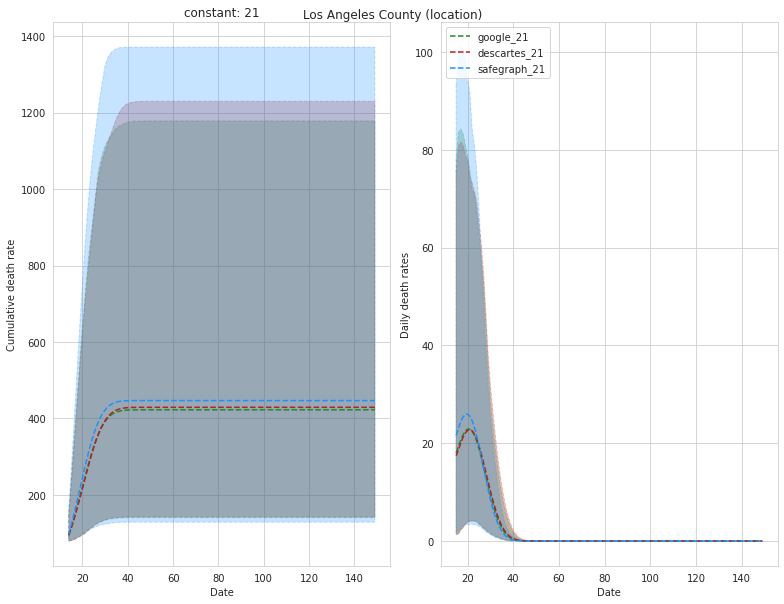

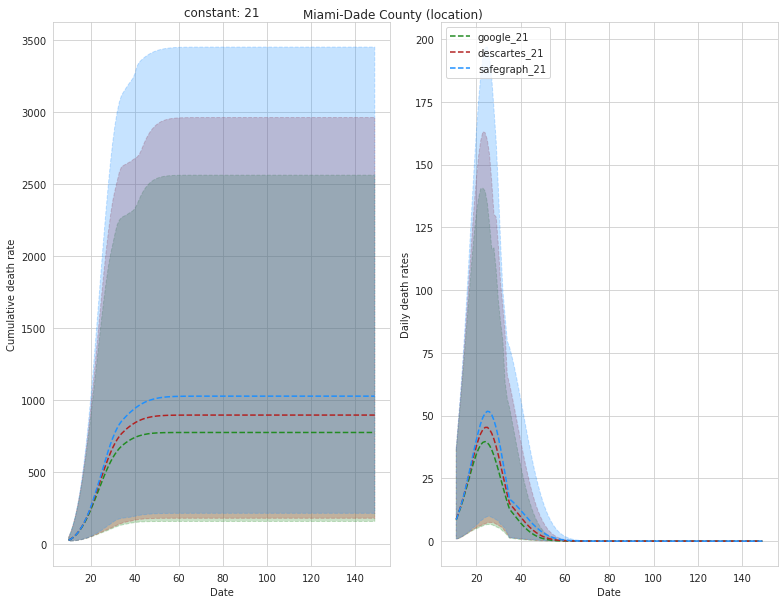

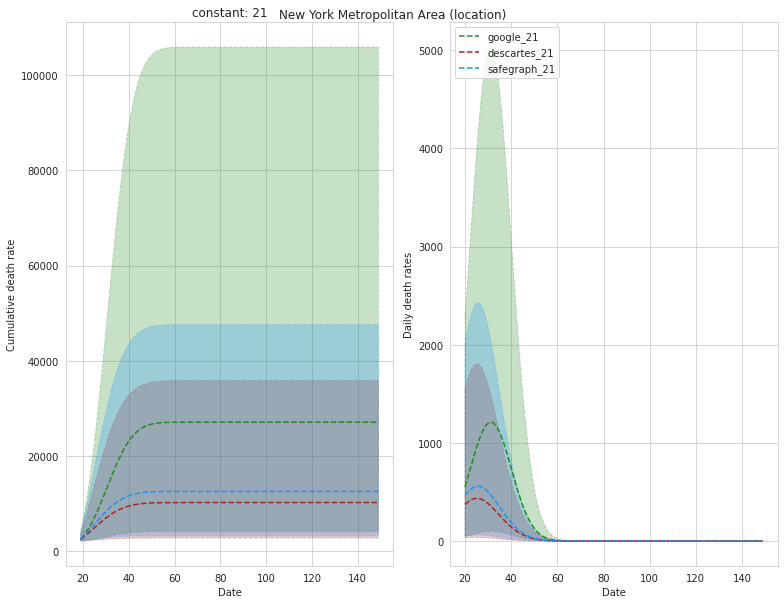

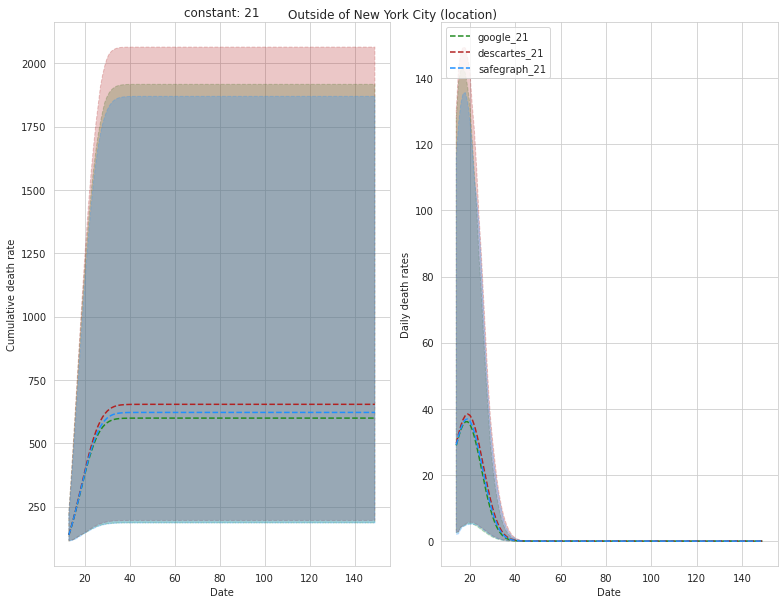

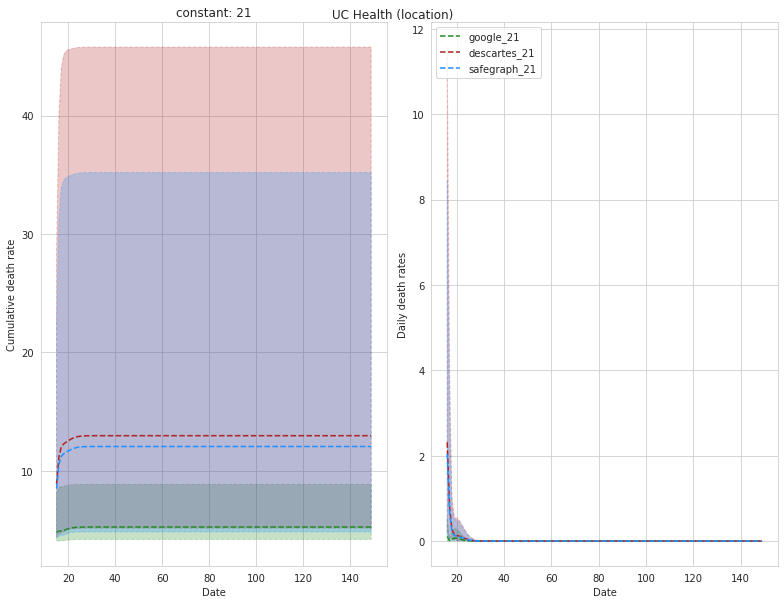

In [21]:
# combine everything
#date_df = pd.read_csv('/ihme/covid-19/deaths/dev/2020_04_22_Counties/threshold_dates.csv')
draw_dfs = []
past_draw_dfs = []
models_used = []
with PdfPages(f'{OUTPUT_DIR}/ensemble_plot.pdf') as pdf:
    for location_id, location_name in zip(euro_df['location_id'], euro_df['Location']):
        print(location_name)
        peak_duration = 1
        data_draws = Drawer(
            ensemble_dirs=submodel_dict[int(location_id)]['submodel_dirs'],
            n_draws_list=submodel_dict[int(location_id)]['n_draws_list'],
            location_name=location_name,
            location_id=int(location_id),
            peak_duration=1,
            obs_df=input_full_df[input_full_df['location_id'] == int(location_id)],
            date_draws=date_df.loc[date_df['location'] == location_name, [i for i in date_df.columns if i.startswith('death_date_draw_')]].values,
            population=input_age_pop_df.loc[input_age_pop_df['location_id'] == int(location_id), 'population'].sum(),
        )
        draw_df, past_draw_df, model_used, days, ensemble_draws = data_draws.get_dated_draws()
        draw_dfs.append(draw_df)
        past_draw_dfs.append(past_draw_df)
        models_used.append(model_used)

        # plot ensemble
        fig, ax = plt.subplots(1, 2, figsize=(11, 8.5))
        for label, draws in ensemble_draws.items():
            label = label.split('model_data_')[1]
            draws = np.exp(draws) * input_age_pop_df.loc[input_age_pop_df['location_id'] == int(location_id), 'population'].sum()
            deaths_mean = draws.mean(axis=0)
            deaths_lower = np.percentile(draws, 2.5, axis=0)
            deaths_upper = np.percentile(draws, 97.5, axis=0)

            d_deaths_mean = (draws[:,1:] - draws[:,:-1]).mean(axis=0)
            d_deaths_lower = np.percentile(draws[:,1:] - draws[:,:-1], 2.5, axis=0)
            d_deaths_upper = np.percentile(draws[:,1:] - draws[:,:-1], 97.5, axis=0)

            # cumulative
            ax[0].fill_between(days,
                               deaths_lower, deaths_upper,
                               color=COLOR_DICT[label.split('_')[0]],
                               linestyle=LINE_DICT[label.split('_')[1]],
                               alpha=0.25)
            ax[0].plot(days, deaths_mean,
                       c=COLOR_DICT[label.split('_')[0]],
                       linestyle=LINE_DICT[label.split('_')[1]], )
            ax[0].set_title(f'constant: {k}')
            ax[0].set_xlabel('Date')
            ax[0].set_ylabel('Cumulative death rate')

            # daily
            ax[1].fill_between(days[1:],
                               d_deaths_lower, d_deaths_upper,
                               color=COLOR_DICT[label.split('_')[0]],
                               linestyle=LINE_DICT[label.split('_')[1]],
                               alpha=0.25)
            ax[1].plot(days[1:], d_deaths_mean,
                       c=COLOR_DICT[label.split('_')[0]],
                       linestyle=LINE_DICT[label.split('_')[1]],
                       label=label.replace('model_data_', ''))
            ax[1].set_xlabel('Date')
            ax[1].set_ylabel('Daily death rates')

        ax[1].legend(loc=2)
        plt.suptitle(f'{location_name} ({model_used})')
        plt.tight_layout()
        pdf.savefig()
if 'location' not in models_used:
    raise ValueError('No location-specific draws used, must be using wrong tag')
draw_df = pd.concat(draw_dfs)
model_type_df = pd.DataFrame({
    'location':euro_df['Location'].to_list(),
    'model_used':models_used
})

# write
if 'draw_999' not in draw_df.columns:
    draw_df['draw_999'] = draw_df['draw_998']

draw_df.to_csv(f'{OUTPUT_DIR}/county_data.csv', index=False)
model_type_df.to_csv(f'{OUTPUT_DIR}/county_models_used.csv', index=False)
print(f'{OUTPUT_DIR}/countt_data.csv')


In [ ]:
input_age_pop_df[input_age_pop_df['location_id']==957]

## combine with previous predictions

In [ ]:
## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ##
# raw_draw_path = f'{OUTPUT_DIR}/euro_data.csv'
# average_draw_path = f'{OUTPUT_DIR}/past_avg_euro_data.csv'
# yesterday_draw_path = '/ihme/covid-19/deaths/prod/2020_04_17_Europe/euro_data.csv'
# before_yesterday_draw_path = '/ihme/covid-19/deaths/prod/2020_04_16_Europe/euro_data.csv'
## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ## ##

# Will this work?
if combine_predictions:
    avg_df = moving_average_predictions(
        today_data_path=raw_draw_path,
        yesterday_data_path=yesterday_draw_path,
        day_before_yesterday_path=before_yesterday_draw_path
    )
    avg_df['date'] = pd.to_datetime(avg_df['date'])
    past_draw_df = pd.concat(past_draw_dfs)

    ## NO NEED TO DO THIS, FOR NOW ##
    # avg_df = get_peak_date(past_draw_df, avg_df)

    # store data
    avg_df.to_csv(average_draw_path, index=False)
    print(average_draw_path)

    # plot
    plotter = CompareAveragingModelDeaths(
        raw_draw_path=raw_draw_path,
        average_draw_path=average_draw_path,
        yesterday_draw_path=yesterday_draw_path,
        before_yesterday_draw_path=before_yesterday_draw_path
        )
    plotter.make_some_pictures(f'{OUTPUT_DIR}/moving_average_compare.pdf',
                                'EEA + Australia + New Zealand')


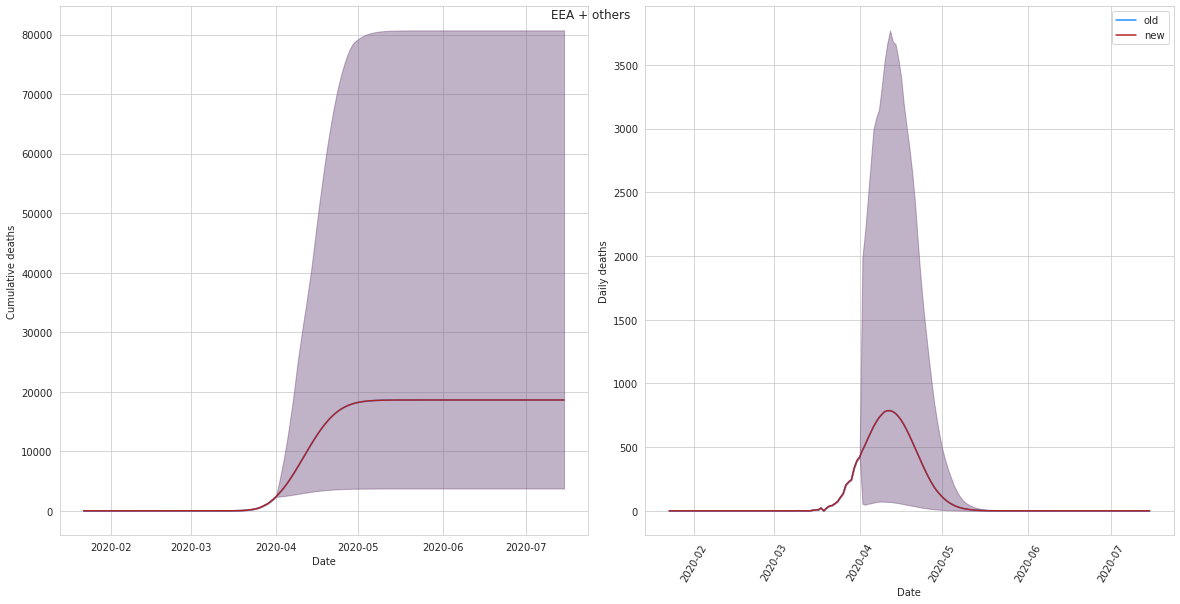

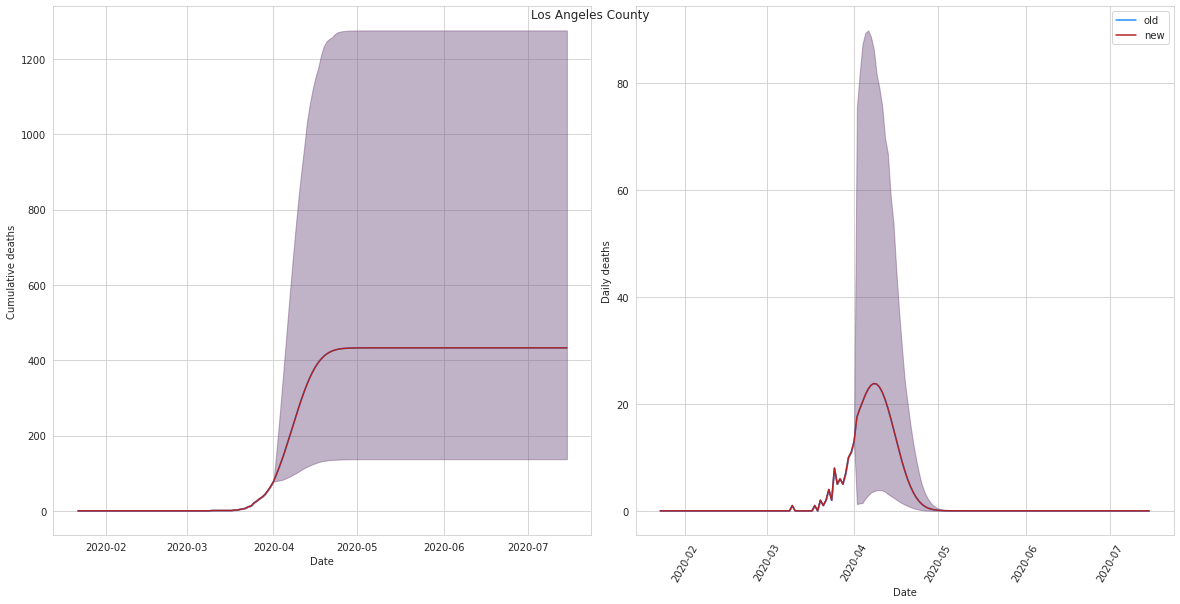

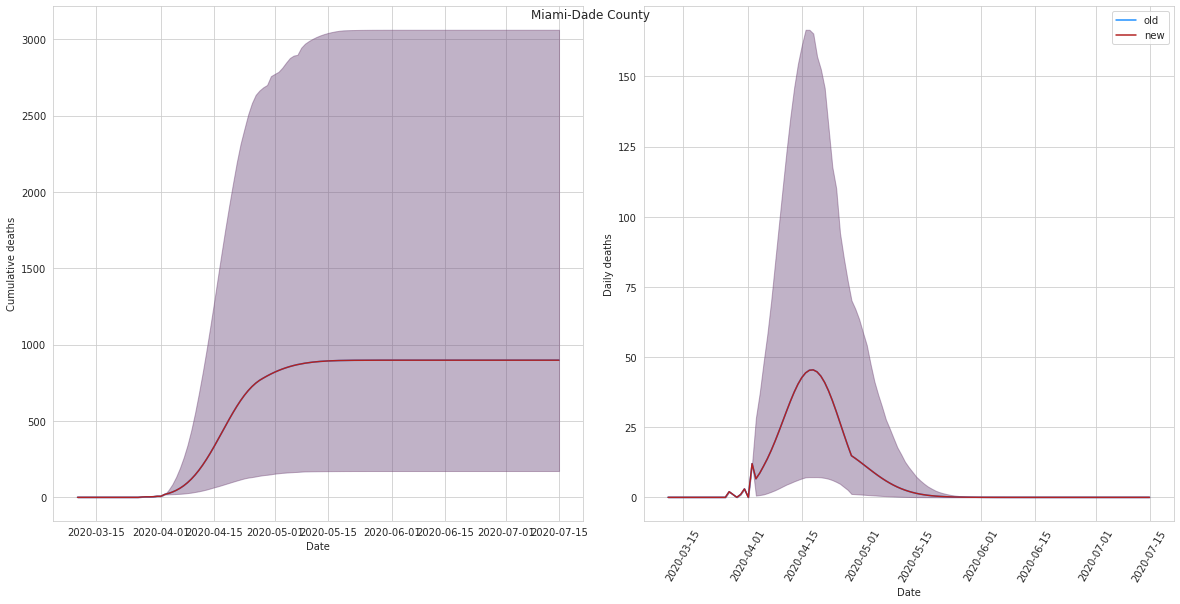

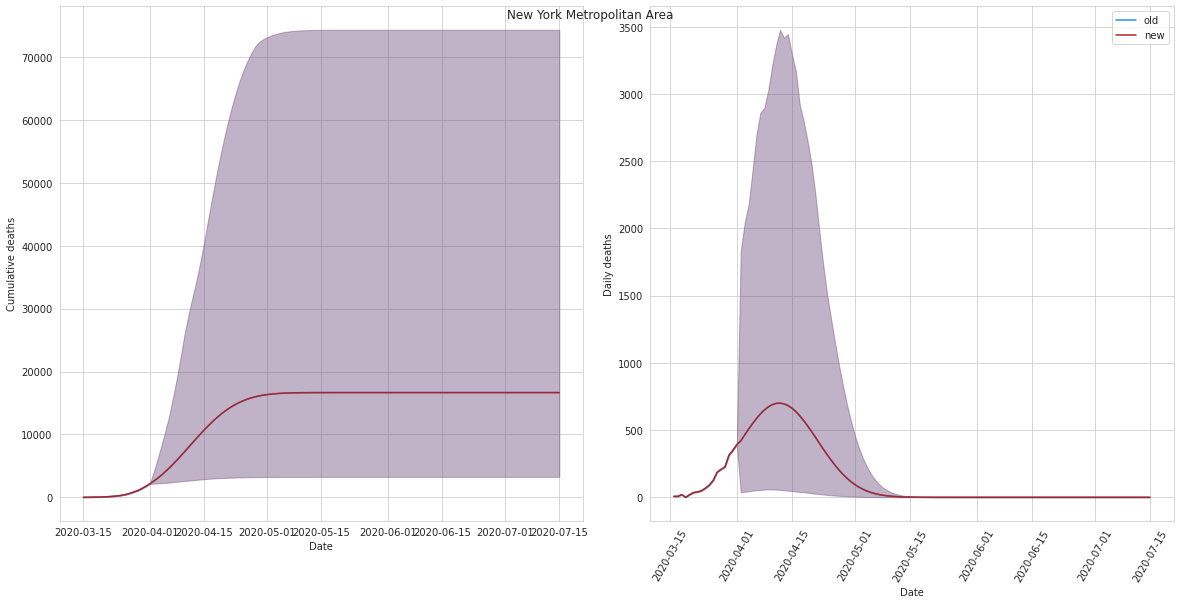

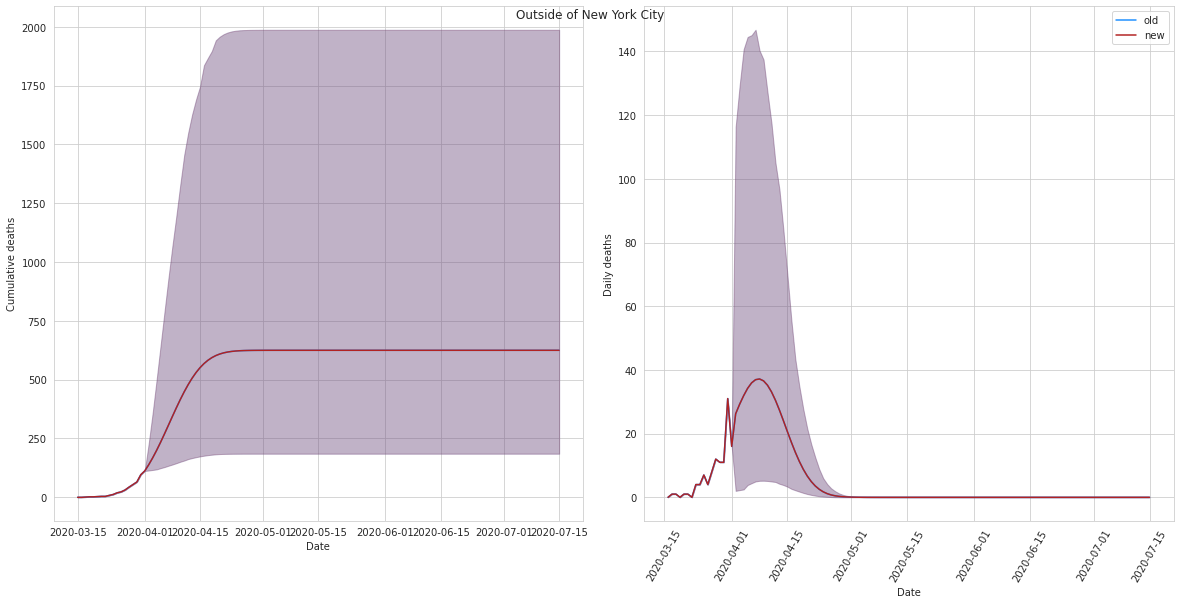

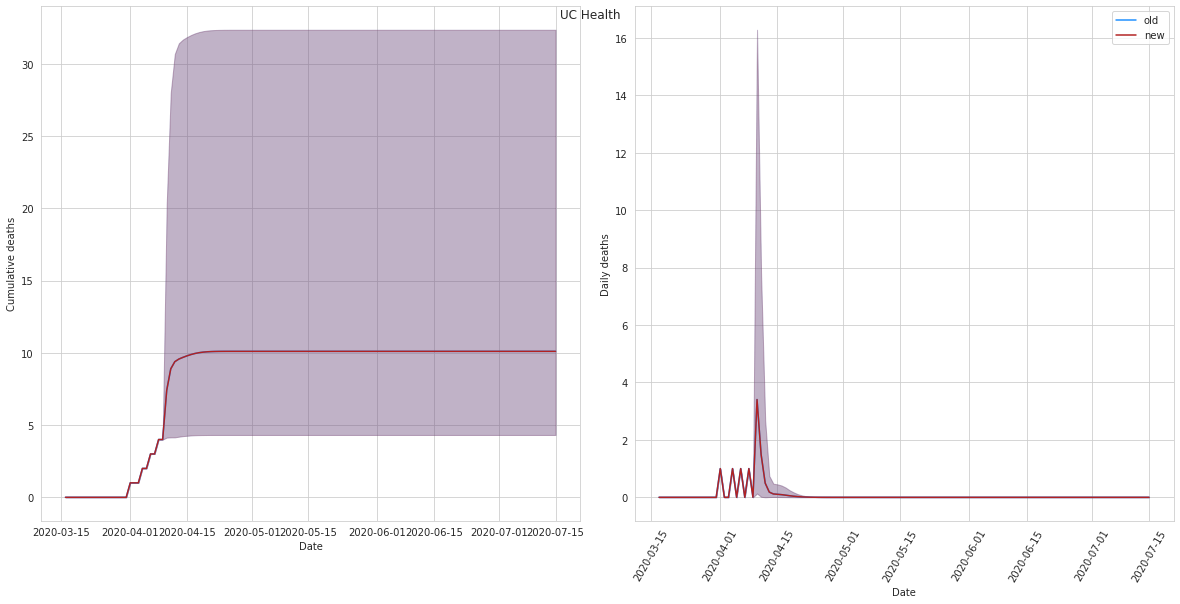

In [22]:
plotter = CompareModelDeaths(
    old_draw_path='/ihme/covid-19/deaths/dev/2020_04_22_Counties/county_data.csv',
    new_draw_path='/ihme/covid-19/deaths/dev/2020_04_22_Counties/county_data.csv'
)
plotter.make_some_pictures(f'{OUTPUT_DIR}/compare_to_previous.pdf',
                           'EEA + others')


In [23]:
viz_dir = f'/home/j/Project/covid/results/diagnostics/deaths/{DATESTAMP_LABEL}_Counties/'
if not os.path.exists(viz_dir):
    os.mkdir(viz_dir)
for viz_fp in ['compare_to_previous.pdf','ensemble_plot.pdf']: #'moving_average_compare.pdf']:
    shutil.copyfile(src=f"{OUTPUT_DIR}/{viz_fp}", dst=f"{viz_dir}/{viz_fp}")


In [ ]:
print(viz_dir)